In [1]:
import sys
sys.path.append("..")
sys.path.append("../env")

from env.Cylinder_Rotation_Env import Cylinder_Rotation_Env
import numpy as np
import matplotlib.pyplot as plt 
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from tqdm import tqdm, trange
from fenics import * 
from timeit import default_timer

from models import *
from utils import *

# Environment Initialization

In [2]:
# env init
env = Cylinder_Rotation_Env(params={'dtr': 0.1, 'T': 1, 'rho_0': 1, 'mu' : 1/1000,
                                    'traj_max_T': 20, 'dimx': 128, 'dimy': 64,
                                    'min_x' : 0,  'max_x' : 2.2, 
                                    'min_y' : 0,  'max_y' : 0.41, 
                                    'r' : 0.05,  'center':(0.2, 0.2),
                                    'min_w': -1, 'max_w': 1,
                                    'min_velocity': -1, 'max_velocity': 1,
                                    'U_max': 1.5, })

print(env.params)

# one step: 10 timestamps for dT = 1

/opt/conda/envs/pytorch-py3.8/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


start init_solve
end init_solve
{'dtr': 0.1, 'T': 1, 'rho_0': 1, 'mu': 0.001, 'traj_max_T': 20, 'dimx': 128, 'dimy': 64, 'min_x': 0, 'max_x': 2.2, 'min_y': 0, 'max_y': 0.41, 'r': 0.05, 'center': (0.2, 0.2), 'min_w': -1, 'max_w': 1, 'min_velocity': -1, 'max_velocity': 1, 'U_max': 1.5}


# Global setting

In [3]:
# env params
dT = env.params['T']
nx = env.params['dimx']
ny = env.params['dimy']
print('dT: {}, ny: {}, nx: {}'.format(dT, ny, nx))

# mosel params setting
L = 4
modes = 12
width = 20

# data path
data_path = './data/nse_data_N0_25_nT_10'

dT: 1, ny: 64, nx: 128


# Phase 1

### Setting

In [4]:
# setting of text, train, model

# output text
ftext = open('./logs/nse_operator_fno_test.txt', 'a', encoding='utf-8')

# param setting
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

epochs = 500
batch_size = 20
lr = 1e-2
wd = 1e-4
step_size = 100
gamma = 0.5
# weight = args.weight

lambda1 = 1
lambda2 = 1
lambda3 = 1

fname = './logs/nse_operator_fno_test'
    
# model setting
model = FNO_ensemble(modes, modes, width, L).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

print('# Params of phase 1 training')
print(f'epochs: {epochs}\nbatch size: {batch_size}\nlearning rate: {lr}\nweight decay: {wd}\nstep size:{step_size}\ngamma: {gamma}')

# Params of phase 1 training
epochs: 500
batch size: 20
learning rate: 0.01
weight decay: 0.0001
step size:100
gamma: 0.5


### Load data

In [5]:
# load data and set params of data

# load data
data, _, Cd, Cl, ang_vel = torch.load(data_path)

# data param
ny = data.shape[2] 
nx = data.shape[3]
s = data.shape[2] * data.shape[3]     # ny * nx
N0 = data.shape[0]                    # num of data sets
nt = data.shape[1] - 1             # nt
Ndata = N0 * nt

print('# Data size')
print('N0: {}, nt: {}, ny: {}, nx: {}'.format(N0, nt, ny, nx))

class NSE_Dataset(Dataset):
    def __init__(self, data, Cd, Cl, ang_vel):
        Cd = Cd.reshape(N0, nt, 1, 1, 1).repeat([1, 1, ny, nx, 1]).reshape(-1, ny, nx, 1)
        Cl = Cl.reshape(N0, nt, 1, 1, 1).repeat([1, 1, ny, nx, 1]).reshape(-1, ny, nx, 1)
        ang_vel = ang_vel.reshape(N0, nt, 1, 1, 1).repeat([1, 1, ny, nx, 1]).reshape(-1, ny, nx, 1)
        input_data = data[:, :-1].reshape(-1, ny, nx, 3)
        output_data = data[:, 1:].reshape(-1, ny, nx, 3)

        self.input_data = torch.cat((input_data, ang_vel), dim=-1)
        self.output_data = torch.cat((output_data, Cd, Cl), dim=-1)
        
    def __len__(self):
        return Ndata

    def __getitem__(self, idx):
        x = torch.FloatTensor(self.input_data[idx])
        y = torch.FloatTensor(self.output_data[idx])
        return x, y

NSE_data = NSE_Dataset(data, Cd, Cl, ang_vel)
train_data, test_data = random_split(NSE_data, [int(0.8 * Ndata), int(0.2 * Ndata)])
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

# Data size
N0: 25, nt: 99, ny: 128, nx: 64


### Train model

In [6]:
# train phase 1
pbar = tqdm(total=epochs, file=sys.stdout)
for epoch in range(1, epochs+1):
    model.train()
    
    t1 = default_timer()
    train_loss = AverageMeter()
    train_loss1 = AverageMeter()
    train_loss2 = AverageMeter()
    train_loss3 = AverageMeter()
    train_loss4 = AverageMeter()
    test_loss = AverageMeter()
    test_loss1 = AverageMeter()
    test_loss2 = AverageMeter()
    test_loss3 = AverageMeter()
    test_loss4 = AverageMeter()

    for x_train, y_train in train_loader:
        x_train, y_train = x_train.to(device), y_train.to(device)
        
        optimizer.zero_grad()

        # split data read in train_loader
        in_train, f_train = x_train[:, :, :, :3], x_train[:, 0, 0, 3]
        out_train, Cd_train, Cl_train = y_train[:, :, :, :3], y_train[:, 0, 0, 3], y_train[:, 0, 0, 4]
        # put data into model
        pred, x_rec, f_rec, trans_out = model(in_train, f_train)
        out_latent = model.stat_en(out_train)
        in_rec = x_rec[:, :, :, :3]
        # prediction items
        out_pred = pred[:, :, :, :3]
        Cd_pred = torch.mean(pred[:, :, :, 3].reshape(batch_size, -1), 1)
        Cl_pred = torch.mean(pred[:, :, :, 4].reshape(batch_size, -1), 1)

        # loss1: prediction loss; loss2: rec loss of state
        # loss3: rec loss of f; loss4: latent loss
        loss1 = F.mse_loss(out_pred, out_train, reduction='mean')\
                + F.mse_loss(Cd_pred, Cd_train, reduction='mean') \
                + F.mse_loss(Cl_pred, Cl_train, reduction='mean')
        loss2 = F.mse_loss(in_train, in_rec, reduction='mean')
        loss3 = F.mse_loss(f_train, f_rec, reduction='mean')
        loss4 = F.mse_loss(out_latent, trans_out, reduction='mean')
        loss = loss1 + lambda1 * loss2 + lambda2 * loss3 + lambda3 * loss4
        
        loss.backward()
        optimizer.step()

        train_loss.update(loss.item(), x_train.shape[0])
        train_loss1.update(loss1.item(), x_train.shape[0])
        train_loss2.update(loss2.item(), x_train.shape[0])
        train_loss3.update(loss3.item(), x_train.shape[0])
        train_loss4.update(loss3.item(), x_train.shape[0])
    
    scheduler.step()
    model.eval()

    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)

            # split data read in test_loader
            in_test, f_test = x_test[:, :, :, :3], x_test[:, 0, 0, 3]
            out_test, Cd_test, Cl_test = y_test[:, :, :, :3], y_test[:, 0, 0, 3], y_test[:, 0, 0, 4]
            # put data into model
            pred, x_rec, f_rec, trans_out = model(in_test, f_test)
            out_latent = model.stat_en(out_test)
            in_rec = x_rec[:, :, :, :3]
            # prediction items
            out_pred = pred[:, :, :, :3]
            Cd_pred = torch.mean(pred[:, :, :, 3].reshape(batch_size, -1), 1)
            Cl_pred = torch.mean(pred[:, :, :, 4].reshape(batch_size, -1), 1)
            loss1 = F.mse_loss(out_pred, out_test, reduction='mean')\
                    + F.mse_loss(Cd_pred, Cd_test, reduction='mean') \
                    + F.mse_loss(Cl_pred, Cl_test, reduction='mean')
            loss2 = F.mse_loss(in_test, in_rec, reduction='mean')
            loss3 = F.mse_loss(f_test, f_rec, reduction='mean')
            loss4 = F.mse_loss(out_latent, trans_out, reduction='mean')
            loss = loss1 + lambda1 * loss2 + lambda2 * loss3 + lambda3 * loss4

            test_loss.update(loss.item(), x_test.shape[0])
            test_loss1.update(loss1.item(), x_test.shape[0])
            test_loss2.update(loss2.item(), x_test.shape[0])
            test_loss3.update(loss3.item(), x_test.shape[0])
            test_loss4.update(loss3.item(), x_test.shape[0])
        
    t2 = default_timer()

    ftext.write('# {} | (train) loss1: {:1.2e}  loss2: {:1.2e}  loss3: {:1.2e} loss4: {:1.2e} | (test) loss1: {:1.2e} loss2: {:1.2e}  loss3: {:1.2e} loss4: {:1.2e}\n'
                .format(epoch, train_loss1.avg, train_loss2.avg, train_loss3.avg, train_loss4.avg, test_loss1.avg, test_loss2.avg, test_loss3.avg, test_loss4.avg))
    
    end = '\r'
    pbar.set_description('# {} | (train) loss1: {:1.2e}  loss2: {:1.2e}  loss3: {:1.2e} loss4: {:1.2e} | (test) loss1: {:1.2e} loss2: {:1.2e}  loss3: {:1.2e} loss4: {:1.2e}\n'
                            .format(epoch, train_loss1.avg, train_loss2.avg, train_loss3.avg, train_loss4.avg, test_loss1.avg, test_loss2.avg, test_loss3.avg, test_loss4.avg))
    pbar.update()
    
ftext.close()
torch.save(model.state_dict(), fname)

epoch 460 | (train) loss1: 2.0008e-03,  loss2: 8.0482e-03,  loss3: 8.3562e-01 | (test) loss1: 2.1353e-03, loss2: 1.6181e-02,  loss3: 7.7791e-01:  92%|█████████▏| 460/500 [14:00<01:06,  1.66s/it]

# Phase 2

### Setting

In [12]:
# param and operator path setting
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
operator_path = './logs/nse_operator_fno_test'

lr = 5e-1
epochs = 1000
step_size = 100
gamma = 0.8

### Load data and model setting

In [48]:
# load_data
data_num = 0
data, _, Cd, Cl, ang_vel = torch.load(data_path, map_location=lambda storage, loc: storage)
data_in = data[data_num].squeeze()[0].to(device)
data_fin = data[data_num].squeeze()[0].to(device)

# data params
ny = data.shape[2] 
nx = data.shape[3]
s = data.shape[2] * data.shape[3]     # ny * nx
N0 = data.shape[0]                    # num of data sets
nt = data.shape[1] - 1                # nt
print('N0: {}, nt: {}, ny: {}, nx: {}'.format(N0, nt, ny, nx))

# load model
load_model = FNO_ensemble(modes, modes, width, L).to(device)
state_dict = torch.load(operator_path)
load_model.load_state_dict(state_dict)
load_model.eval()

for param in list(load_model.parameters()):
    param.requires_grad = False

# set policy net
# p_net = torch.nn.ModuleList([policy_net_cnn().to(device) for _ in range(nt)])
p_net = policy_net_cnn().to(device)

# training
optimizer = torch.optim.Adam(p_net.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

N0: 25, nt: 99, ny: 128, nx: 64


### Train model without env.step()

In [ ]:
# start train of phase2
ftext = open('logs/nse_control_p_test.txt', mode="a", encoding="utf-8")
ftext.write(f"phase2 | data_num: {data_num}")
ftext.write('N0: {}, nt: {}, ny: {}, nx: {}'.format(N0, nt, ny, nx))

for epoch in range(1, epochs + 1):
    p_net.train()
    optimizer.zero_grad()

    ang_optim = torch.rand(nt).to(device)
    out_nn = data_in.reshape(ny, nx, 3).to(device)
    Cd_nn = torch.zeros(nt).to(device)
    Cl_nn = torch.zeros(nt).to(device)
    Cd_obs = torch.zeros(nt).to(device)
    Cl_obs = torch.zeros(nt).to(device)
    for i in range(nt):
        out_nn = out_nn.reshape(1, ny, nx, 3)
        # print('ang_optim[i]: {}'.format(ang_optim[i].size()))
        # ang_optim[i] = p_net(out_nn.reshape(1, -1))
        ang_optim[i] = p_net(out_nn)
        print(ang_optim[i].min(), out_nn.max())
        ang_nn = ang_optim[i].reshape(1, 1, 1, 1).repeat(1, ny, nx, 1)
        # in_nn = torch.cat((out_nn.squeeze(), ang_nn), dim=-1).unsqueeze(0)
        out_nn, Cd_nn[i], Cl_nn[i], ang_rec = load_model(out_nn, ang_nn)
        print(f"epoch: {epoch} | Cd_nn: {Cd_nn[i]} | Cl_nn: {Cl_nn[i]} | ang_rec: {ang_rec.item()} | i: {i}")
    

    loss = torch.mean(Cd_nn ** 2) + 0.1 * torch.mean(Cl_nn ** 2)
    # loss += 0.01 * torch.mean(ang_optim.squeeze() ** 2)
    print("epoch: {:4}  loss: {:1.6f}  Cd_nn: {:1.6f}  Cd_obs: {:1.6f}  Cl_nn: {:1.6f}  Cl_obs: {:1.6f}  ang_optim: {:1.6f}"
            .format(epoch, loss, Cd_nn.mean(), Cd_obs.mean(), Cl_nn.mean(), Cl_obs.mean(), ang_optim.mean()))

    loss.backward()
    optimizer.step()
    scheduler.step()
    
    # save log
    ftext.write("epoch: {:4}  loss: {:1.6f}  Cd_nn: {:1.6f}  Cd_obs: {:1.6f}  Cl_nn: {:1.6f}  Cl_obs: {:1.6f}  ang_optim: {:1.6f}\n"
                .format(epoch, loss, Cd_nn.mean(), Cd_obs.mean(), Cl_nn.mean(), Cl_obs.mean(), ang_optim.mean()))
ftext.close()


### Train model with env.step()

In [ ]:
# start train model of phase2 with env
ftext = open('logs/phase2&env.txt', mode="a", encoding="utf-8")
ftext.write(f"phase2&env | data_num: {data_num}")
ftext.write('N0: {}, nt: {}, ny: {}, nx: {}'.format(N0, nt, ny, nx))

for epoch in range(1, epochs + 1):
    env.reset()

    p_net.train()
    optimizer.zero_grad()

    ang_optim = torch.rand(nt).to(device)
    out_nn = data_in.reshape(ny, nx, 3).to(device)
    Cd_nn = torch.zeros(nt).to(device)
    Cl_nn = torch.zeros(nt).to(device)
    Cd_obs = torch.zeros(nt).to(device)
    Cl_obs = torch.zeros(nt).to(device)
    for i in range(nt):
        # print('ang_optim[i]: {}'.format(ang_optim[i].size()))
        # ang_optim[i] = p_net(out_nn.reshape(1, -1))
        ang_optim[i] = p_net[i](out_nn.reshape(1, ny, nx, 3))
        ang_nn = ang_optim[i].reshape(1, 1, 1).repeat(ny, nx, 1)
        in_nn = torch.cat((out_nn.squeeze(), ang_nn), dim=-1).unsqueeze(0)
        out_nn, Cd_nn[i], Cl_nn[i] = load_model(in_nn)
        ang_obs = ang_optim[i].to(torch.device('cpu')).detach().numpy()
        out_obs, _, Cd_obs[i], Cl_obs[i] = env.step(ang_obs)
        # print(f"epoch: {epoch} | Cd_nn: {Cd_nn} | Cl_nn: {Cl_nn} | i: {i}")
    

    loss = torch.mean(Cd_nn ** 2) + 0.1 * torch.mean(Cl_nn ** 2)
    loss += 0.01 * torch.mean(ang_optim.squeeze() ** 2)
    print("epoch: {:4}  loss: {:1.6f}  Cd_nn: {:1.6f}  Cd_obs: {:1.6f}  Cl_nn: {:1.6f}  Cl_obs: {:1.6f}  ang_optim: {:1.6f}"
            .format(epoch, loss, Cd_nn.mean(), Cd_obs.mean(), Cl_nn.mean(), Cl_obs.mean(), ang_optim.mean()))

    loss.backward()
    optimizer.step()
    scheduler.step()
    
    # save log
    ftext.write("epoch: {:4}  loss: {:1.6f}  Cd_nn: {:1.6f}  Cd_obs: {:1.6f}  Cl_nn: {:1.6f}  Cl_obs: {:1.6f}  ang_optim: {:1.6f}"
                .format(epoch, loss, Cd_nn.mean(), Cd_obs.mean(), Cl_nn.mean(), Cl_obs.mean(), ang_optim.mean()))
ftext.close()


# Some test

### no f 

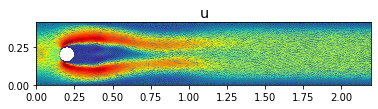

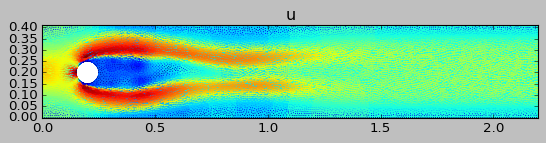

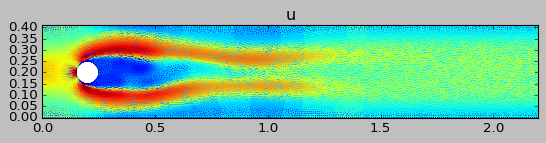

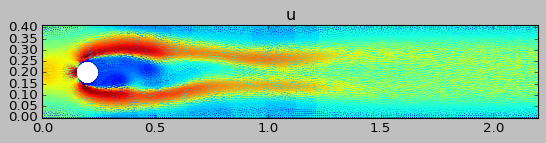

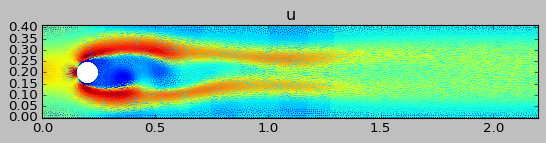

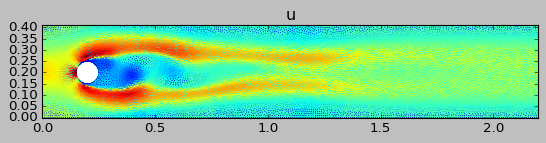

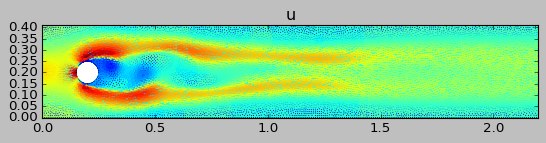

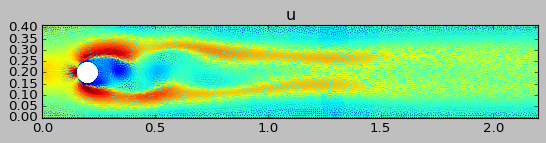

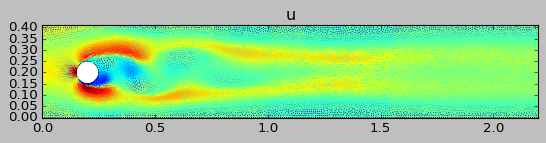

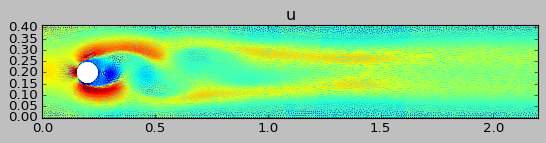

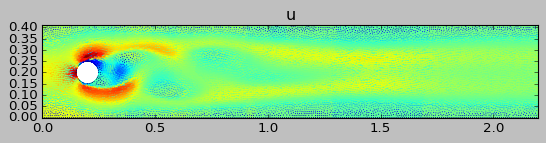

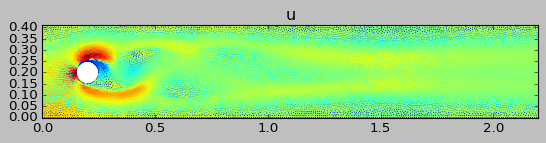

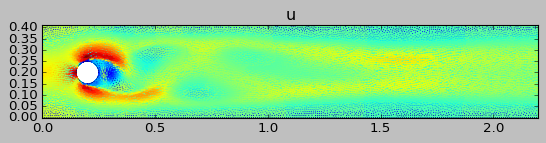

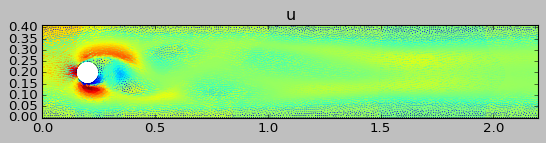

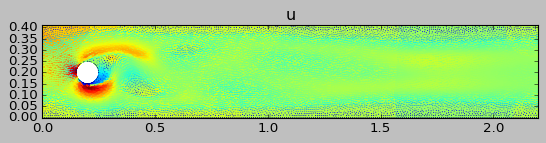

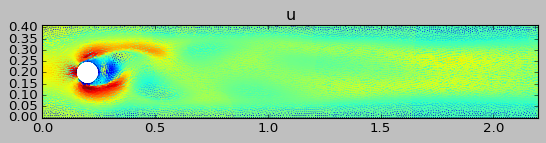

KeyboardInterrupt: 

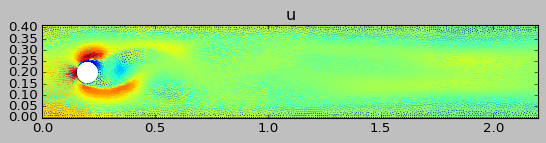

In [3]:
env.reset()

nt = 100
Cd = np.zeros(nt)
Cl = np.zeros(nt)
for i in range(nt):
    f = 0.00
    obs, _, Cd[i], Cl[i] = env.step(f, mode='vertex')
    env.draw()

    

### show plot of given f

In [ ]:
# load data
data = data, _, Cd, Cl, ang_vel = torch.load('data/nse_data_N0_100_nT_100')

# data param
ny = data.shape[2] 
nx = data.shape[3]
s = data.shape[2] * data.shape[3]     # ny * nx
N0 = data.shape[0]                    # num of data sets
nt = data.shape[1] - 1             # nt

env.reset()

for i in range(nt):
    f = ang_vel[i]
    obs, reward, Cd, Cl = env.step(f)
    env.draw()
